# Quick scripting for XPS-tool

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Embedded imports
import os, sys
import math
import matplotlib.pyplot as plt

In [3]:
# Third party imports
import numpy as np
import pandas as pd

In [4]:
# Temporary solution for local imports
sys.path.append('..')
import xpstool.helpers as xpsmodule

In [5]:
# Constants
al_k_alpha = 1486.61 # Al K-alpha photon source energy
p22_energy = 3800 # Photon energy from the p22 beamline

## Nanolab data (Al K-alpha radiation 1486.61 eV)

## Petra III, P22 beamline (Scienta analyzer)

In [6]:
# ---SCIENTA DATA---
# Full path to data files
data_path = "/Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/"
# Folders to add to the full path above 
data_folders = [
    "Data"
]

In [7]:
# List of all directories (combine the full path with specified folders)
all_dirs = ["".join([data_path, data_folder]) for data_folder in data_folders]

# Iterating through directories displaying existing files
all_files = []
for i, dirname in enumerate(sorted(all_dirs)):
    if i > 0: # Just to make it prettier (no empty line before the first output)
        print() # Otherwise, add an empty line to separate outputs
    print(f"all_dirs[{i}]: {dirname}")
    
    # Iterating through the list of files inside the directory. Files are sorted
    # according to the last _number value in their name using lambda function
    files = []
    for j, file in enumerate(sorted(os.listdir(all_dirs[i]))):
        if file.endswith(".txt"):                         
            files.append(file)
            print(f"---> all_files[{i}][{j}]: {file}")
    all_files.append(files)

all_dirs[0]: /Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/Data
---> all_files[0][1]: 0000.txt
---> all_files[0][4]: 0001.txt
---> all_files[0][7]: 0002.txt
---> all_files[0][10]: 0003.txt
---> all_files[0][13]: 0004.txt
---> all_files[0][16]: 0005.txt
---> all_files[0][19]: 0006.txt
---> all_files[0][22]: 0007.txt
---> all_files[0][25]: 0008.txt
---> all_files[0][28]: 0009.txt
---> all_files[0][31]: 0010.txt
---> all_files[0][34]: 0011.txt
---> all_files[0][37]: 0012.txt
---> all_files[0][40]: 0013.txt
---> all_files[0][43]: 0014.txt
---> all_files[0][46]: 0015.txt
---> all_files[0][49]: 0016.txt
---> all_files[0][52]: 0017.txt
---> all_files[0][55]: 0018.txt
---> all_files[0][58]: 0019.txt
---> all_files[0][61]: 0020.txt
---> all_files[0][64]: 0021.txt
---> all_files[0][67]: 0022.txt
---> all_files[0][70]: 0023.txt
---> all_files[0][73]: 0024.txt
---> all_files[0][76]: 0025.txt
---> all_files[0][79]: 0026.txt
---> all_files[0][82]:


Region Name: Ni2p_4600
Lens Mode: T_HiPPHAXPES
Pass Energy: 100
Number of Sweeps: 2
Excitation Energy: 3.10021844987699E-317
Energy Scale: Kinetic
Acquisition Mode: Swept
Energy Unit: Kinetic
Center Energy: 3732
Low Energy: 3716
High Energy: 3748
Energy Step: 0.1
Step Time: 143
Detector First X-Channel: 1
Detector Last X-Channel: 512
Detector First Y-Channel: 1
Detector Last Y-Channel: 460
Number of Slices: 1
File: D:\Data\2018_11_RhFebeamtime\0139.pxt,.ibw,.txt
Sequence: D:\SES_1.7.2_Win64_Package\SES_1.7.2_Win64\Sequences\factory.seq
Spectrum Name: Ni2p_4600
Instrument: HiPP-2 10kV-9862
Location: 
User: 
Sample: 
Comments: Testing the voltage output;
Date: 2018-11-19
Time: 14:28:05
Time per Spectrum Channel: 24.596
DetectorMode: ADC


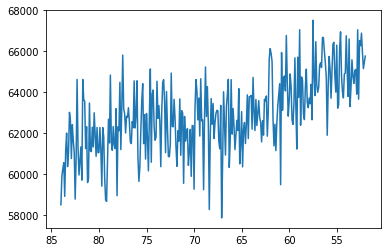

In [13]:
# Plot preview of a Scienta.txt file
with open("/".join([all_dirs[0], all_files[0][139]])) as f:
    lines = f.read().splitlines()

# Dictionary that contains the map of the file, where the name of the section is
# the key and the list of first and last indices of Info and Data sections is the value
# Example: {"Region 1": [[3, 78], [81, 180]]}
#                         Info      Data
file_map = {}
    
# The number of regions is given in the second line of the file
regions_number = int(lines[1].split("=")[1])
# If number of regions higher than one, we'll need to make a list of scan objects
scans = []

# Temporary counter to know the currently treated region number in the 
# for-loop below
cnt = 1
# Temporary list variables to store the first and the last indices of the 
# info and the data file blocks for every region
info_indices = []
data_indices = []

# Parsing below assumes that the file structure is constant and the blocks
# follow the sequence:
# [Region N]
# [Info N]
# [Data N]
for i, line in enumerate(lines):
    if ("[Region %d]" % cnt) in line:
        # If it is not the first region, than the data section of the previous region
        # ends on the previous line
        if cnt > 1:
            data_indices.append(i-1) 
        continue
    if ("[Info %d]" % cnt) in line:
        info_indices.append(i+1)  
        continue
    if ("[Data %d]" % cnt) in line:
        info_indices.append(i-1)
        data_indices.append(i+1)
        if cnt == regions_number:
            data_indices.append(len(lines)-1)
            break
        else:
            cnt += 1    

# Reseting region number counter to 1 to start again from the first region
cnt = 1
for j in range(1, len(info_indices), 2):
    file_map[f"Region {cnt}"] = [[info_indices[j-1], info_indices[j]], [data_indices[j-1], data_indices[j]]]
    cnt += 1

    # Iterating through regions            
for val in file_map.values():
    energy, counts = [], []
    # Parsing Data block of the current region 
    data_block = lines[val[1][0]:val[1][1]+1]
    for line in data_block:
        if not line.strip():
            continue # Scip empty lines
        else:
            xy = line.split()
            x = float(xy[0].strip())
            y = float(xy[1].strip())
            if y > 0:
                energy.append(x)
                counts.append(y)

    # If the energy values in the file were on the kinetic scale,
    # Transform them to binding scale
    binding_energy = [p22_energy - value for value in energy]
    # Info block of the current region 
    info_lines = lines[val[0][0]:val[0][1]+1]

    scans.append(xpsmodule.Scan(binding_energy, counts, info=xpsmodule.parseScientaFileInfo(info_lines)))

    #%matplotlib qt # Plotting in a separate interactive window
    if regions_number == 1:
        print(scans[0])
        plt.plot(scans[0].Data["energy"], scans[0].Data["counts"])
        plt.gca().invert_xaxis()
    else:
        fig, axs = plt.subplots(int(math.ceil(len(scans)/2)),2)
        for i, scan in enumerate(scans):
            axs[i].plot(scan.Data["energy"], scan.Data["counts"])
            axs[i].invert_xaxis()